In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [2]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()



In [3]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K

def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/((L-1)*L)
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

# Function to plot covariance matrix as an ellipse
def plot_covariance_matrix(ax, center, covariance, chi2_val, edgecolor='blue', alpha=0.5, n_std = 1 ):
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues * chi2_val)  
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, edgecolor=edgecolor, fc=edgecolor, alpha=alpha)
    return ellipse

In [4]:
# Chi2 para el nivel de confianza deseado (1σ ≈ 68.27%)
chi2_val = chi2.ppf(0.6827, df=2)
#chi2_val = 1 # sim 39%

In [5]:
from scipy.stats import chi2

# Grados de libertad
df = 2

valor_critico = 1
# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(valor_critico, df)
valor_critico_inversa = chi2.ppf(probabilidad, df)
print(f"Valor crítico: {valor_critico_inversa}")
print(f"Probabilidad: {probabilidad}")


print('\n')

# Usamos ppf para obtener el valor crítico
probabilidad = 0.68
valor_critico = chi2.ppf(probabilidad, df)

# Usamos cdf para obtener la probabilidad original
probabilidad_inversa = chi2.cdf(valor_critico, df)

print(f"Valor crítico: {valor_critico}")
print(f"Probabilidad inversa: {probabilidad_inversa}")

Valor crítico: 1.0
Probabilidad: 0.3934693402873665


Valor crítico: 2.27886856637673
Probabilidad inversa: 0.68


In [6]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
K = construct_K(vectors)
print('Tensor of Inertia: {}'.format(K))

#I = compute_inertia_tensor_cm(vectors, np.ones(3))
#print('Tensor of Inertia: {}'.format(I))

eigenvalues, eigenvectors = np.linalg.eig(K)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))
print('The volume of the ellipsoid is given by the square root of the determinant of K: {}'.format(np.sqrt(np.linalg.det(K))))

Center of mass: [-0.23570226 -0.40824829]
Tensor of Inertia: [[ 0.58333333 -0.28867513]
 [-0.28867513  0.25      ]]
Eigenvalues: [0.75       0.08333333]
Eigenvectors: [[ 0.8660254  0.5      ]
 [-0.5        0.8660254]]
The volume of the ellipsoid is given by the square root of the determinant of K: 0.25


Plot this information:

# Variando las covarianzas

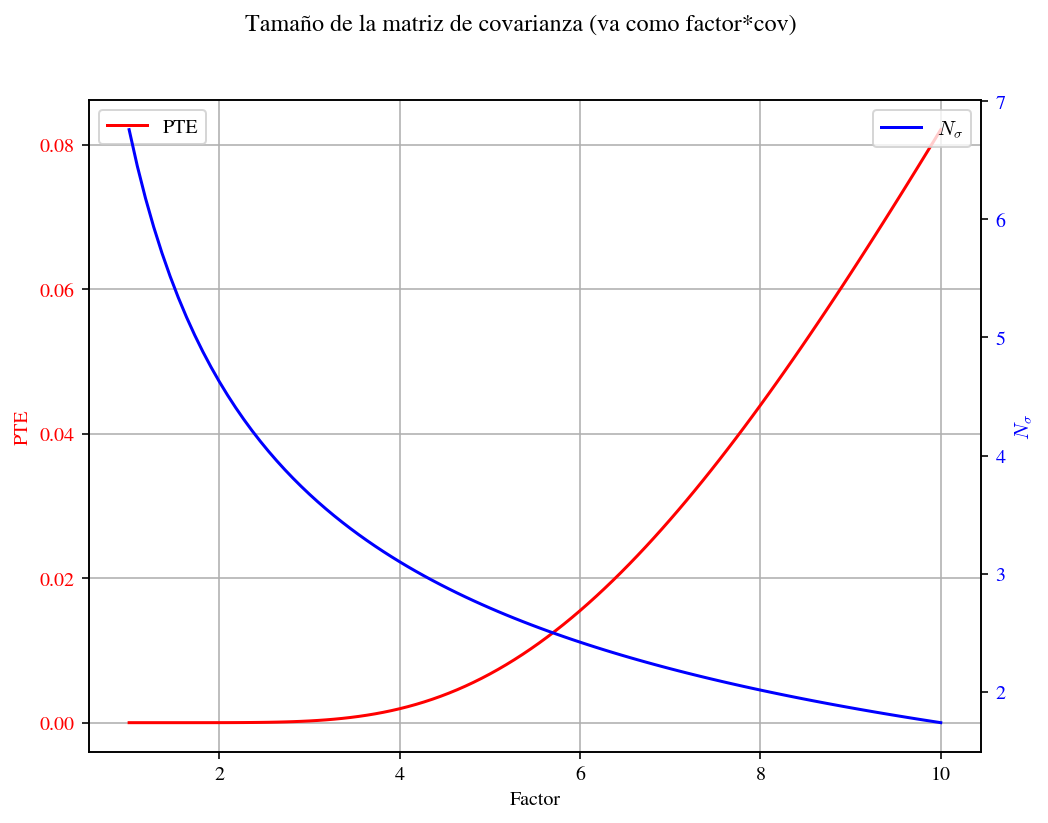

In [7]:
#Sharp triangle
d = 2
L = 3  # Number of vector
factor = np.linspace(1, 10, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, np.sqrt(3)/2.])

    cov_A = factor[i] * np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    vectors = np.array([r_1, r_2, r_3])
    R_CM = calculate_R_CM(vectors)

    PTE_arr[i] = gamma(a=d/2, scale=(2*4)/L**2).sf(np.linalg.norm(R_CM)**2)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Tamaño de la matriz de covarianza (va como factor*cov)')

ax1 = axes
ax2 = ax1.twinx()

ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_xlabel('Factor')
ax1.set_ylabel('PTE', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')

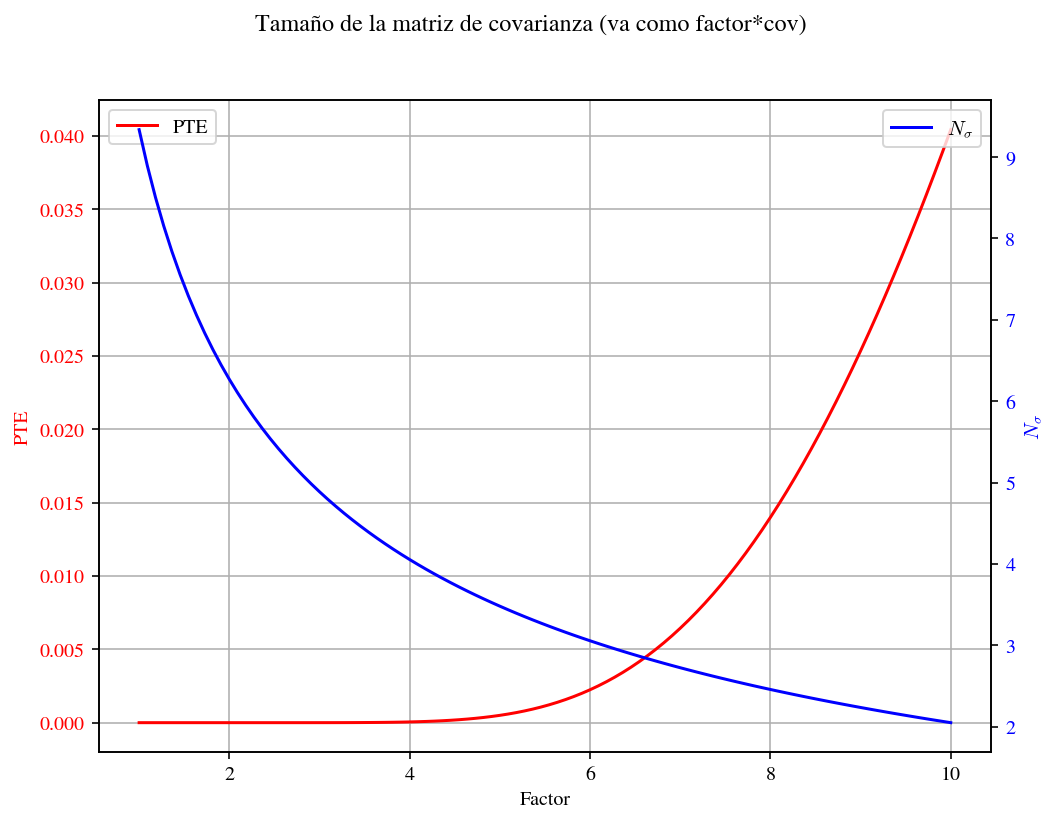

In [8]:
#Sharp triangle
d = 2
L = 3  # Number of vector
factor = np.linspace(1, 10, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, np.sqrt(3)/2.])

    cov_A = factor[i] * np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE_arr[i] = gamma(a=d, scale=1).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Tamaño de la matriz de covarianza (va como factor*cov)')

ax1 = axes
ax2 = ax1.twinx()

ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_xlabel('Factor')
ax1.set_ylabel('PTE', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.


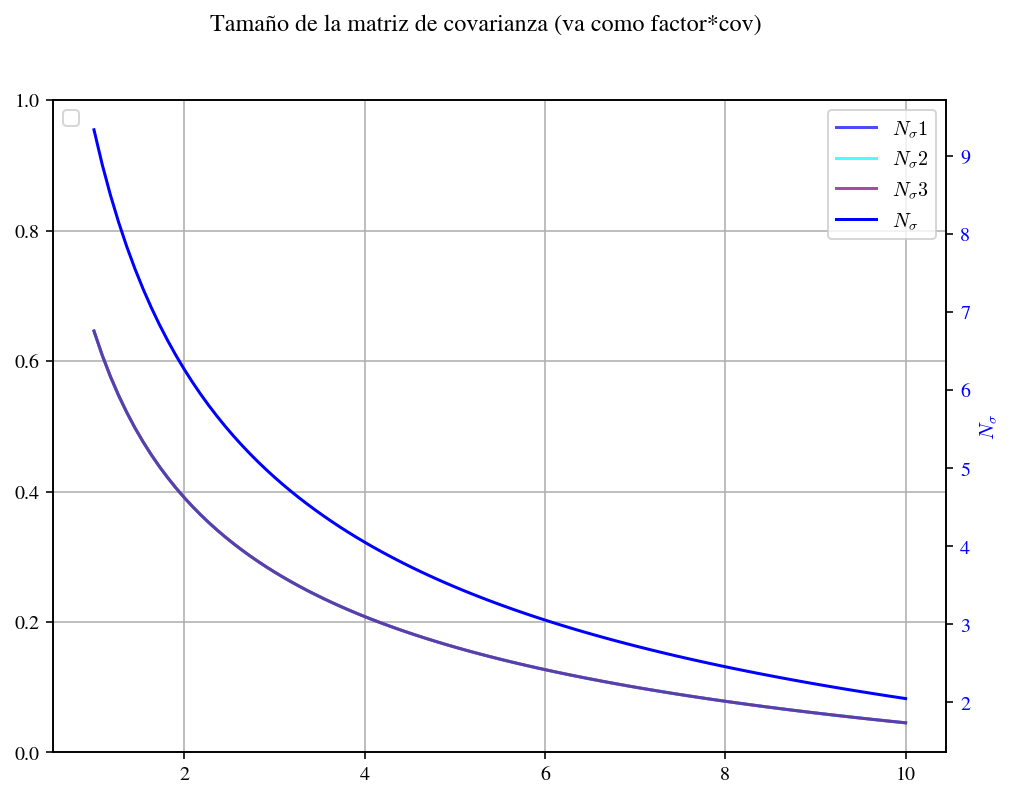

In [9]:
#Sharp triangle
d = 2
L = 3  # Number of vector

factor = np.linspace(1, 10, 100)
PTE_arr_1 = np.zeros(len(factor))
n_sigma_arr_1 = np.zeros(len(factor))
PTE_arr_2 = np.zeros(len(factor))
n_sigma_arr_2 = np.zeros(len(factor))
PTE_arr_3 = np.zeros(len(factor))
n_sigma_arr_3 = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, np.sqrt(3)/2.])

    cov_A = factor[i] * np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    r1_2 = np.linalg.norm(r_1)**2
    r2_2 = np.linalg.norm(r_2)**2
    r3_2 = np.linalg.norm(r_3)**2

    PTE_arr_1[i] = chi2(d).sf(r1_2)
    n_sigma_arr_1[i] = np.sqrt(2)*erfcinv(PTE_arr_1[i])

    PTE_arr_2[i] = chi2(d).sf(r2_2)
    n_sigma_arr_2[i] = np.sqrt(2)*erfcinv(PTE_arr_2[i])

    PTE_arr_3[i] = chi2(d).sf(r3_2)
    n_sigma_arr_3[i] = np.sqrt(2)*erfcinv(PTE_arr_3[i])


fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Tamaño de la matriz de covarianza (va como factor*cov)')

ax1 = axes
ax2 = ax1.twinx()

#ax1.plot(factor, PTE_arr_1, label='PTE', color='red')
#ax1.plot(factor, PTE_arr_2, label='PTE', color='orange')
#ax1.plot(factor, PTE_arr_3, label='PTE', color='green')
#ax1.set_xlabel('Factor')
#ax1.set_ylabel('PTE', color='red')
#ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr_1, label='$N_\sigma 1$', color='blue', alpha=0.7)
ax2.plot(factor, n_sigma_arr_2, label='$N_\sigma 2$', color='cyan', alpha=0.7)
ax2.plot(factor, n_sigma_arr_3, label='$N_\sigma 3$', color='purple', alpha=0.7)
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')

# Variando la media de la posterior del medio

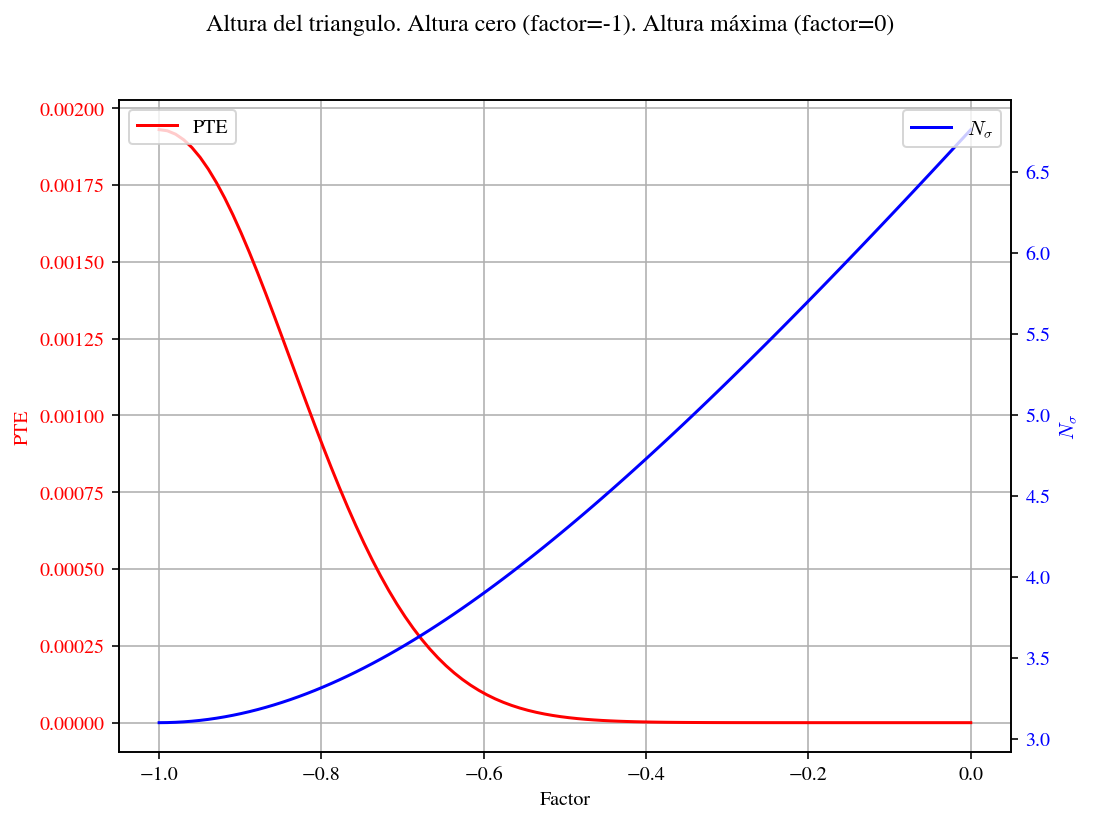

In [10]:
#Sharp triangle
d = 2
L = 3  # Number of vector
factor = np.linspace(-1, 0, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, (1+factor[i])*np.sqrt(3)/2.])

    cov_A = np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    vectors = np.array([r_1, r_2, r_3])
    R_CM = calculate_R_CM(vectors)

    PTE_arr[i] = gamma(a=d/2, scale=(2*4)/L**2).sf(np.linalg.norm(R_CM)**2)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Altura del triangulo. Altura cero (factor=-1). Altura máxima (factor=0)')

ax1 = axes
ax2 = ax1.twinx()

ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_xlabel('Factor')
ax1.set_ylabel('PTE', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_mean.png'), dpi=300, bbox_inches='tight')


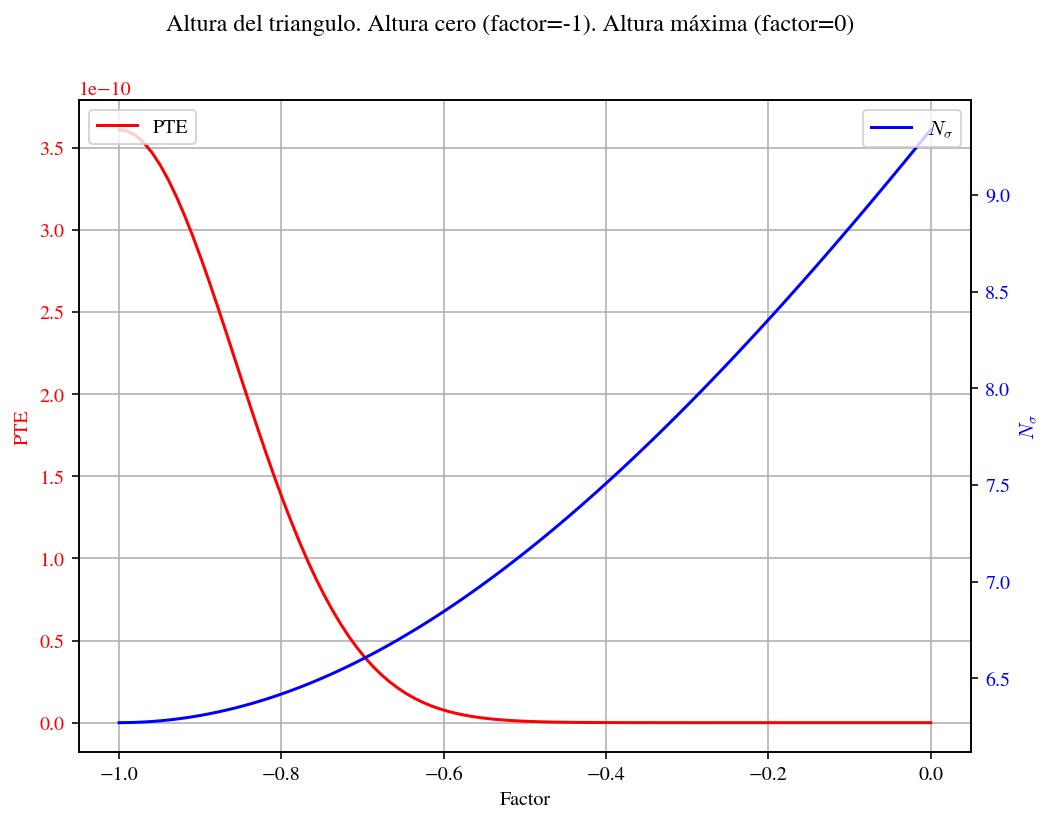

In [11]:
#Sharp triangle
d = 2
L = 3  # Number of vector
factor = np.linspace(-1, 0, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, (1+factor[i])*np.sqrt(3)/2.])

    cov_A = np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE_arr[i] = gamma(a=d, scale=1).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Altura del triangulo. Altura cero (factor=-1). Altura máxima (factor=0)')

ax1 = axes
ax2 = ax1.twinx()

ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_xlabel('Factor')
ax1.set_ylabel('PTE', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.


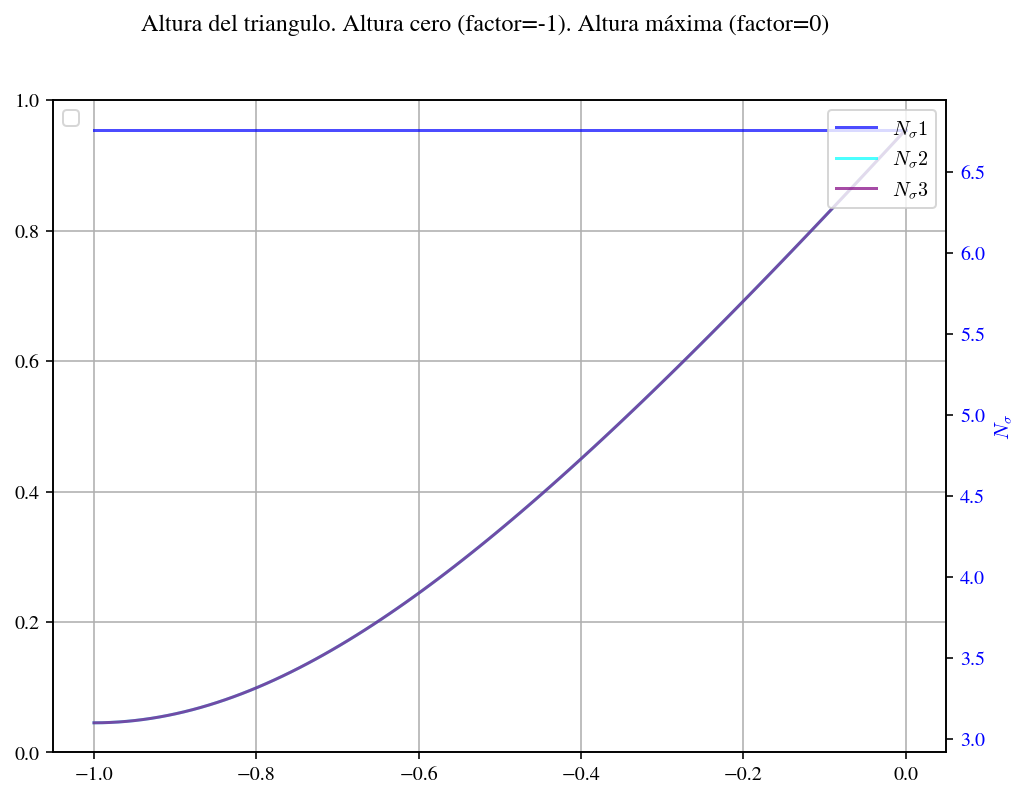

In [12]:
#Sharp triangle
d = 2
L = 3  # Number of vector
factor = np.linspace(-1, 0, 100)

PTE_arr_1 = np.zeros(len(factor))
n_sigma_arr_1 = np.zeros(len(factor))
PTE_arr_2 = np.zeros(len(factor))
n_sigma_arr_2 = np.zeros(len(factor))
PTE_arr_3 = np.zeros(len(factor))
n_sigma_arr_3 = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = np.array([-1/2., 0.]) 
    mean_B = np.array([1/2, 0.])
    mean_C = np.array([0, (1+factor[i])*np.sqrt(3)/2.])

    cov_A = np.array([[0.01, 0.], [0., 0.01]])
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    r1_2 = np.linalg.norm(r_1)**2
    r2_2 = np.linalg.norm(r_2)**2
    r3_2 = np.linalg.norm(r_3)**2

    PTE_arr_1[i] = chi2(d).sf(r1_2)
    n_sigma_arr_1[i] = np.sqrt(2)*erfcinv(PTE_arr_1[i])

    PTE_arr_2[i] = chi2(d).sf(r2_2)
    n_sigma_arr_2[i] = np.sqrt(2)*erfcinv(PTE_arr_2[i])

    PTE_arr_3[i] = chi2(d).sf(r3_2)
    n_sigma_arr_3[i] = np.sqrt(2)*erfcinv(PTE_arr_3[i])


fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Altura del triangulo. Altura cero (factor=-1). Altura máxima (factor=0)')

ax1 = axes
ax2 = ax1.twinx()

#ax1.plot(factor, PTE_arr_1, label='PTE', color='red')
#ax1.plot(factor, PTE_arr_2, label='PTE', color='orange')
#ax1.plot(factor, PTE_arr_3, label='PTE', color='green')
#ax1.set_xlabel('Factor')
#ax1.set_ylabel('PTE', color='red')
#ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(factor, n_sigma_arr_1, label='$N_\sigma 1$', color='blue', alpha=0.7)
ax2.plot(factor, n_sigma_arr_2, label='$N_\sigma 2$', color='cyan', alpha=0.7)
ax2.plot(factor, n_sigma_arr_3, label='$N_\sigma 3$', color='purple', alpha=0.7)
ax2.set_ylabel('$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')

# Case 1

In [13]:
d = 2
L = 3  # Number of vector
names = ['x', 'y']
labels = ['x', 'y']

Center of mass: [-2.3570226 -4.0824829]


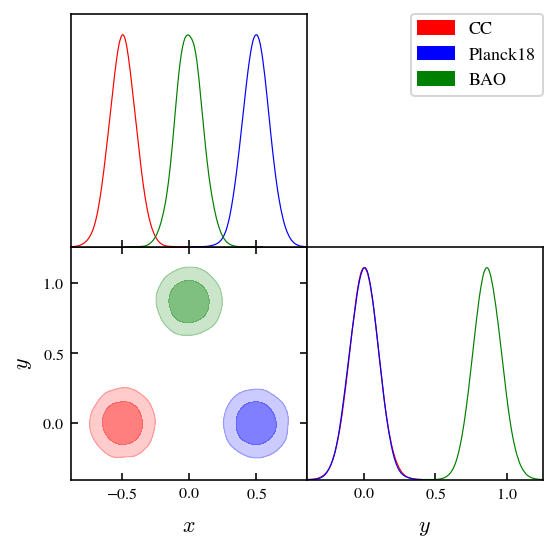

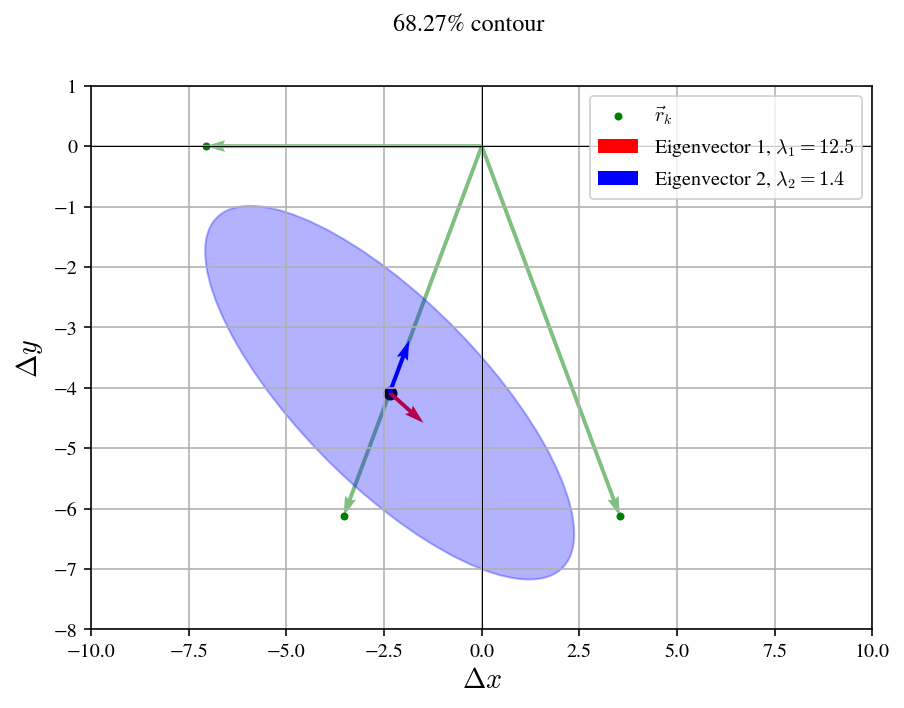

Angle between eigenvectors: 0
PTE = 1.3887943864963998e-11
$N_\sigma_Q$ = 6.75907


PTE = 9.836624224615916e-21
$N_\sigma_beta$ = 9.33779


PTE = 1.3887943864963998e-11
$N_\sigma_max$ = 6.75907


PTE = 1.3887943864963998e-11
$N_\sigma_min$ = 6.75907


In [14]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)



ax.grid()
ax.legend()

os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

N_sigma= 6.75814 \pm 0.075103


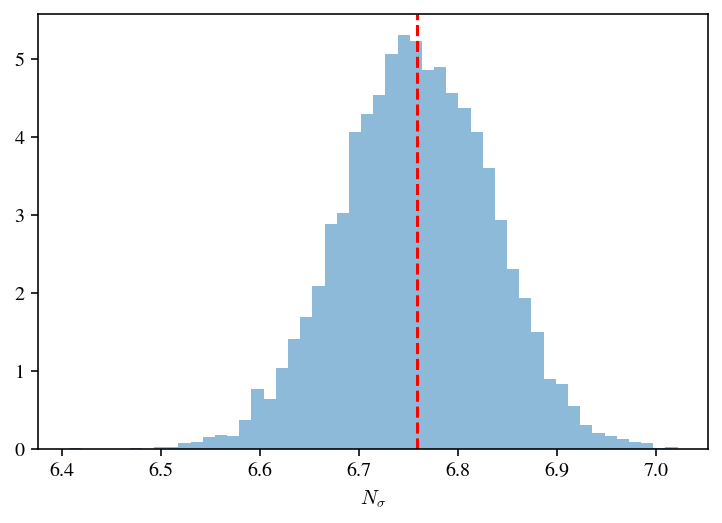

In [15]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

#samples = np.random.normal(np.linalg.norm(R_CM), np.sqrt(sigma2_radial), size=10000)**2
samples = np.random.normal(np.linalg.norm(R_CM)**2, sigma2_radial, size=10000)

samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(samples))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))


In [ ]:
samples = np.random.multivariate_normal(R_CM, C/L, size=100000)
samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(np.linalg.norm(samples,axis=1)**2))#-np.trace(C)/L))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

Center of mass: [-1.05409255 -1.82574186]


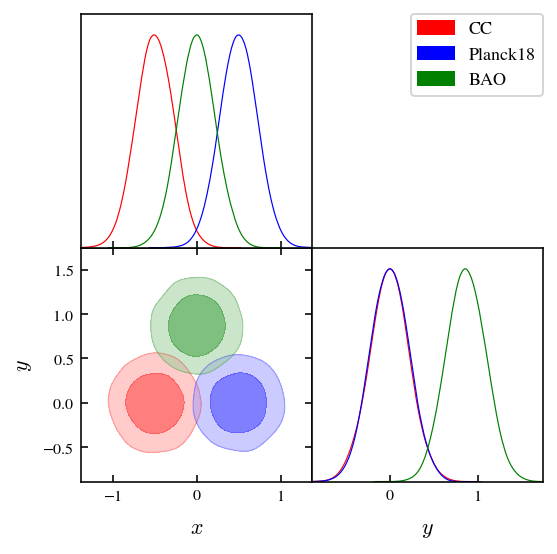

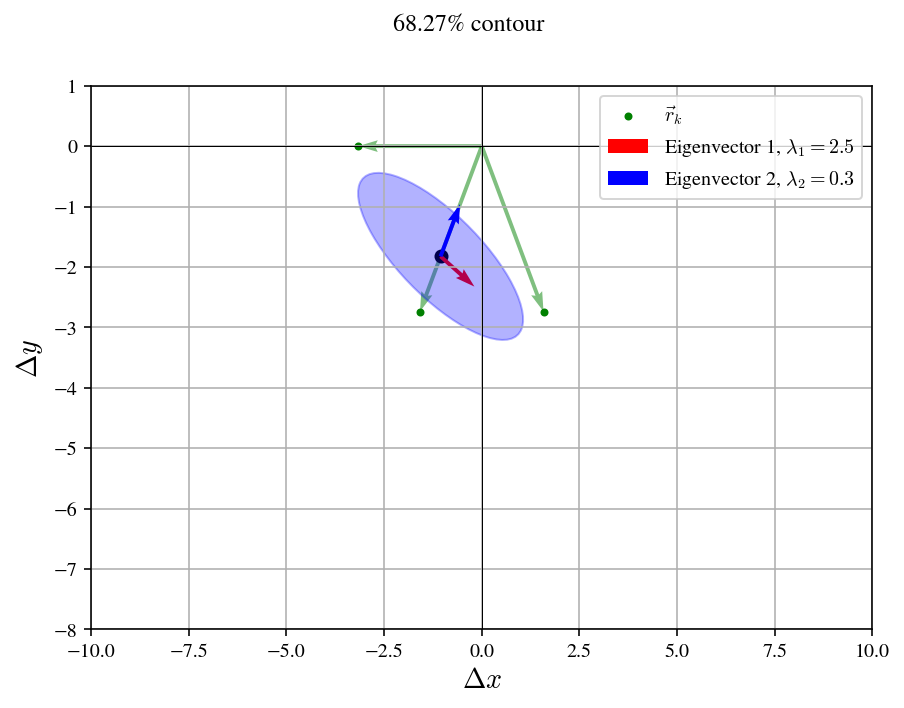

Angle between eigenvectors: 0
PTE = 0.00673794699908546
$N_\sigma_Q$ = 2.70953


PTE = 0.0004993992273873326
$N_\sigma_beta$ = 3.48108


PTE = 0.00673794699908546
$N_\sigma_max$ = 2.70953


PTE = 0.00673794699908546
$N_\sigma_min$ = 2.70953


In [17]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 5*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)
#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)



ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

N_sigma= 2.70913 \pm 0.0346734


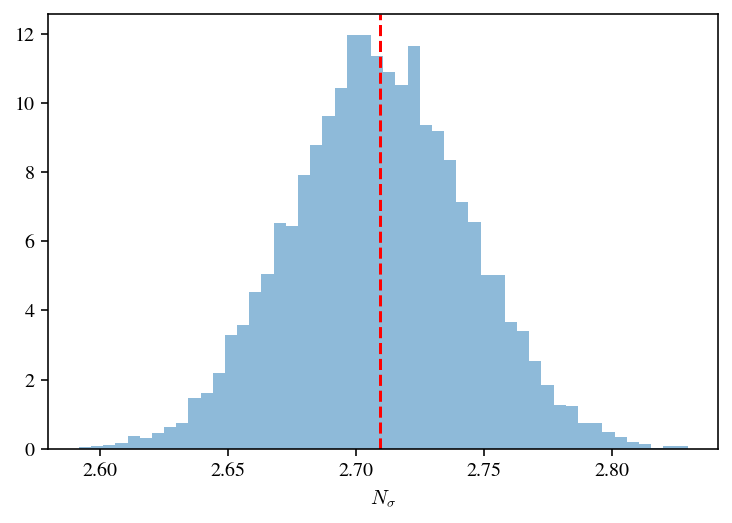

In [18]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

#samples = np.random.normal(np.linalg.norm(R_CM), np.sqrt(sigma2_radial), size=10000)**2
samples = np.random.normal(np.linalg.norm(R_CM)**2, sigma2_radial, size=10000)

samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(samples))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

N_sigma= 2.98968 \pm 0.578221


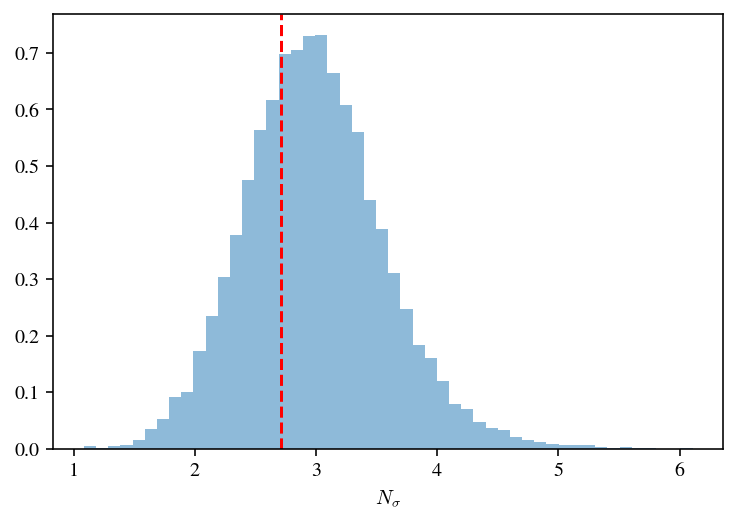

In [19]:
samples = np.random.multivariate_normal(R_CM, C/L, size=10000)
samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(np.linalg.norm(samples,axis=1)**2))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

In [20]:
# Los valores medidos no son iguales! EL hecho de que la metrica R_CM de lo mismo que los individuales implica que no hace falta una escala de Jeffreys!
print(min_r2, max_r2, np.linalg.norm(R_CM)**2)

10.000000000000002 10.000000000000002 4.444444444444445


Center of mass: [-2.72165527  0.        ]


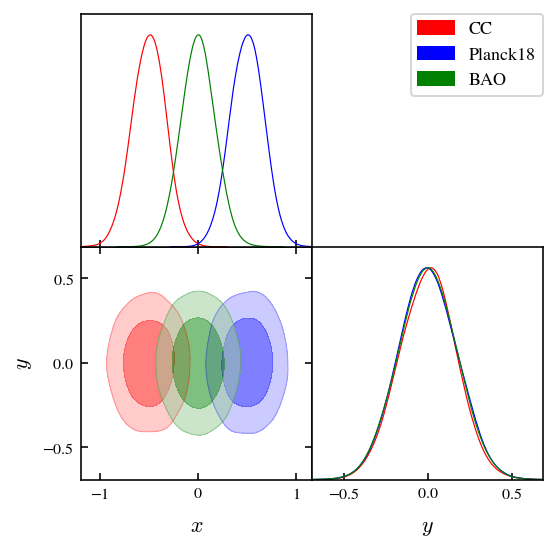

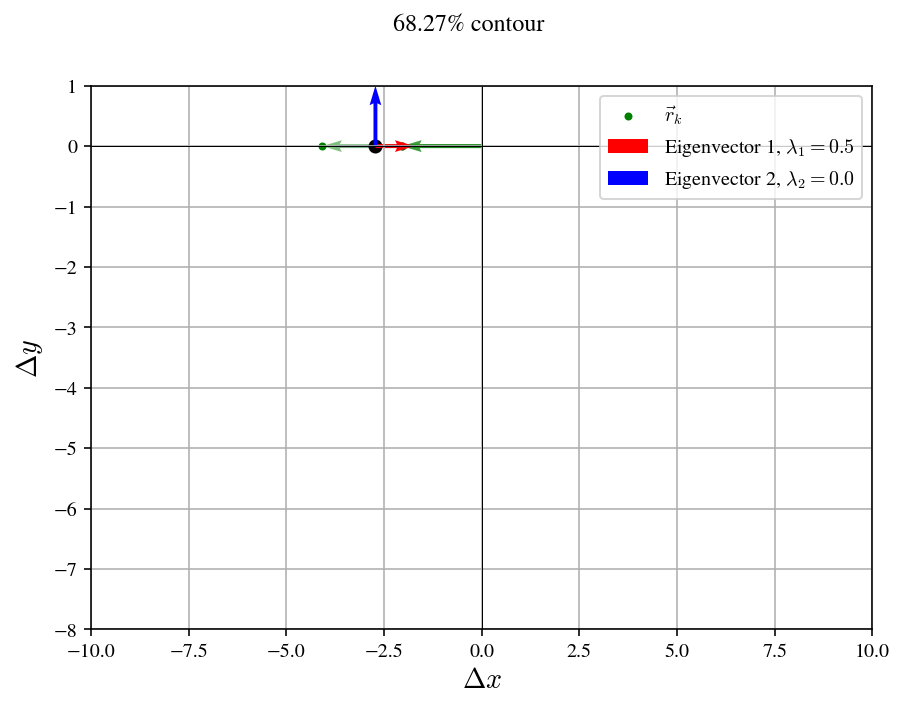

Angle between eigenvectors: 0
PTE = 0.00024036947641951404
$N_\sigma_Q$ = 3.67231


PTE = 0.002243448446582131
$N_\sigma_beta$ = 3.05596


PTE = 0.00024036947641951404
$N_\sigma_max$ = 3.67231


PTE = 0.12451447144412299
$N_\sigma_min$ = 1.5361


In [23]:

'''
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 10*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()
'''

mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = 3*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()


# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = -np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
#samps_Rcm = multivariate_normal(R_CM, C)
#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)



ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

In [ ]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

#samples = np.random.normal(np.linalg.norm(R_CM), np.sqrt(sigma2_radial), size=10000)**2
samples = np.random.normal(np.linalg.norm(R_CM)**2, sigma2_radial, size=10000)

samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(samples))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

In [ ]:
samples = np.random.multivariate_normal(R_CM, C/L, size=10000)
samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(np.linalg.norm(samples,axis=1)**2))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

In [ ]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

samples = np.random.multivariate_normal(R_CM, C/L, size=10000)

# Case 2

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 100*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)


#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

# Case 3

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)



#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

In [ ]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

#samples = np.random.normal(np.linalg.norm(R_CM), np.sqrt(sigma2_radial), size=10000)**2
samples = np.random.normal(np.linalg.norm(R_CM)**2, sigma2_radial, size=10000)

samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(samples))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

In [ ]:
samples = np.random.multivariate_normal(R_CM, C/L, size=10000)
samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(np.linalg.norm(samples,axis=1)**2))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

# Case 4

In [ ]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

# Plot the distribution of the center of mass   

lim_x = np.array([-10, 10])
lim_y = np.array([-8, 1])

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))


# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
#print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
#print('Eigenvalues: {}'.format(eigenvalues))
#print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)



ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

PTE = gamma(a=d/2, scale=8/9).sf(np.linalg.norm(R_CM)**2)
n_sigma_q = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_Q$ = {n_sigma_q:.3g}')

print('\n')

beta_L = (np.linalg.norm(r_1)**2+np.linalg.norm(r_2)**2+np.linalg.norm(r_3)**2)/L
PTE = gamma(a=d, scale=1).sf(beta_L)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_beta$ = {n_sigma:.3g}')

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')

In [ ]:
r_cm = R_CM/ np.linalg.norm(R_CM)

sigma2_radial = np.dot(r_cm.T,np.dot(C/L, r_cm)) # This is the tension vector squared

#samples = np.random.normal(np.linalg.norm(R_CM), np.sqrt(sigma2_radial), size=10000)**2
samples = np.random.normal(np.linalg.norm(R_CM)**2, sigma2_radial, size=10000)

samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(samples))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma_q, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

In [ ]:
samples = np.random.multivariate_normal(R_CM, C/L, size=10000)
samples_n_sigma = np.sqrt(2)*erfcinv(gamma(a=d/2, scale=8/9).sf(np.linalg.norm(samples,axis=1)**2))
plt.hist(samples_n_sigma, bins=50, density=True, alpha=0.5, label='Samples $N_\sigma$')
plt.axvline(n_sigma, color='red', linestyle='--', label='$N_\sigma_Q$')
plt.xlabel('$N_\sigma$')

print('N_sigma= {:.3g} \pm {:.3g}'.format(np.mean(samples_n_sigma), np.std(samples_n_sigma)))

# Real data

In [ ]:
import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared parameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


In [ ]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
K = construct_K(vectors)
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(K))
eigenvalues, eigenvectors = np.linalg.eig(K)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

lim_x = np.array([-5, 5])
lim_y = np.array([-8, 1])

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
g.export('dist_data.pdf')


fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm = multivariate_normal(R_CM, C)

# Usamos cdf para obtener la probabilidad original
probabilidad = chi2.cdf(chi2_val, d)
# Plot the covariance matrix C
fig.suptitle('{:.3g}% contour'.format(probabilidad*100))
ellipse = plot_covariance_matrix(ax, R_CM, C, chi2_val, edgecolor='blue', alpha=0.3)
ax.add_patch(ellipse)

#ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0],r_4[0], r_5[0], r_6[0]], 
           [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], 
           marker='.',color='green', label=r'$\vec{r}_{k}$')

ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')


ax.text(R_CM[0]-0.1, R_CM[1]+0.3, 'CM')
ax.text(r_1[0]-0.5, r_1[1]+0.2, '(CC, Planck18)', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, '(CC, BAO)')
ax.text(r_3[0]-0.0, r_3[1]-0.3, '(Planck18, BAO)')
ax.text(r_4[0]-0.3, r_4[1]-0.4, '(CC, PPS)')
ax.text(r_5[0]-0.1, r_5[1]-0.5, '(Planck18, PPS)')
ax.text(r_6[0]-0.3, r_6[1]+0.2, '(BAO, PPS)')


ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)

ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)


ax.grid()
#ax.legend(loc='lower right')
ax.legend()


os.chdir(os.path.join(path_git, 'notebooks', 'figures'))
#fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

print('Angle between eigenvectors:{:.3g}'.format(np.dot(eigenvectors[0, :], eigenvectors[1, :]))) # Should be zero for orthogonal vectors

In [ ]:
d = 2
L = 6  # Number of vector

# Compute some statistic values:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)

num_samples = int(1e5)

samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)
samps_D_H0 = np.random.multivariate_normal(0*mean_D, cov_D, size=num_samples)


samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0
samps_delta_theta_AD_H0 = samps_A_H0 - samps_D_H0
samps_delta_theta_BD_H0 = samps_B_H0 - samps_D_H0
samps_delta_theta_CD_H0 = samps_C_H0 - samps_D_H0

R_samples_H0 = np.zeros(num_samples)
beta_L_samples_H0 = np.zeros(num_samples)
for i in range(len(R_samples_H0)):
  r_1_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (samps_delta_theta_AB_H0[i,:]))
  r_2_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (samps_delta_theta_AC_H0[i,:]))
  r_3_H0 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (samps_delta_theta_BC_H0[i,:]))
  r_4_H0 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (samps_delta_theta_AD_H0[i,:]))
  r_5_H0 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (samps_delta_theta_BD_H0[i,:]))
  r_6_H0 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (samps_delta_theta_CD_H0[i,:]))
  vectors_H0 = np.array([r_1_H0, r_2_H0, r_3_H0, r_4_H0, r_5_H0, r_6_H0])
  R_CM_H0 = calculate_R_CM(vectors_H0)
  R_samples_H0[i] = np.linalg.norm(R_CM_H0)**2

  beta_L_samples_H0[i] = (np.linalg.norm(r_1_H0)**2 + np.linalg.norm(r_2_H0)**2 + np.linalg.norm(r_3_H0)**2 + np.linalg.norm(r_4_H0)**2 + np.linalg.norm(r_5_H0)**2 + np.linalg.norm(r_6_H0)**2)/L

#print(R_samples_H0)
PTE = R_samples_H0[R_samples_H0 > np.linalg.norm(R_CM)**2].size/R_samples_H0.size
print('PTE: {}'.format(PTE))
N_sigma_Q = np.sqrt(2) * erfcinv(PTE)
print(r'$N \sigma_Q$:{:4g}'.format(N_sigma_Q))

print('\n')

#print(beta_L_samples_H0)
beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2 + np.linalg.norm(r_4)**2 + np.linalg.norm(r_5)**2 + np.linalg.norm(r_6)**2)/L
PTE = beta_L_samples_H0[beta_L_samples_H0 > beta_L].size/beta_L_samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma_beta_L$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

print('\n')

max_r2 = np.max([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2, np.linalg.norm(r_4)**2, np.linalg.norm(r_5)**2, np.linalg.norm(r_6)**2])
PTE = chi2(d).sf(max_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_max$ = {n_sigma:.3g}')

print('\n')

min_r2 = np.min([np.linalg.norm(r_1)**2, np.linalg.norm(r_2)**2, np.linalg.norm(r_3)**2, np.linalg.norm(r_4)**2, np.linalg.norm(r_5)**2, np.linalg.norm(r_6)**2])
PTE = chi2(d).sf(min_r2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'$N_\sigma_min$ = {n_sigma:.3g}')



In [ ]:
plt.hist(R_samples_H0, bins=int(np.sqrt(len(R_samples_H0))), density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(np.linalg.norm(R_CM)**2, color='red', linestyle='--', label='alpha')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, mean, ax, chi2_val, **kwargs):
    """
    Dibuja una elipse de confianza en base a un valor de chi2 (Mahalanobis^2 ≤ chi2_val)
    
    Parámetros:
        cov: matriz de covarianza 2x2
        mean: vector de media
        ax: objeto matplotlib.Axes
        chi2_val: valor crítico de chi2 (definiendo nivel de confianza)
        kwargs: argumentos para matplotlib.patches.Ellipse
    """
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Ángulo de rotación en grados
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Longitudes de los ejes
    width, height = 2 * np.sqrt(vals * chi2_val)

    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellip)

# Parámetros de ejemplo
mu = np.array([1.0, 2.0])
Sigma = np.array([[3.0, 1.5],
                  [1.5, 1.0]])

# Crear figura
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*mu, color='red', label='Centro (μ)')

# Elipse A: Mahalanobis^2 ≤ 1 → 39.35%
plot_cov_ellipse(Sigma, mu, ax, chi2_val=1.0, edgecolor='green', facecolor='none', lw=2, label='1σ geom. (39.35%)')

# Elipse B: Mahalanobis^2 ≤ chi2_2(68.27%) ≈ 2.30
chi2_1sigma_2D = chi2.ppf(0.6827, df=2)
plot_cov_ellipse(Sigma, mu, ax, chi2_val=chi2_1sigma_2D, edgecolor='blue', facecolor='none', lw=2, ls='--', label='1σ prob. (68.27%)')

# Personalización
ax.set_xlim(mu[0] - 4, mu[0] + 4)
ax.set_ylim(mu[1] - 4, mu[1] + 4)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
ax.set_title("Comparación de elipses 1σ: geométrica vs. probabilística")

plt.tight_layout()
plt.show()
